In [74]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from dbhelper import pd_query, PgDB

In [22]:
query = '''
        select 
            d.date,
            waittime,
            volume,
            valid,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            minofday,
            minute,
            newyears,
            us_mlk,
            us_washington,
            us_memorial,
            us_independence,
            us_columbus,
            us_veterans,
            us_thanksgiving,
            xmas,
            ca_goodfriday,
            ca_victoria,
            ca_canada,
            ca_civic,
            ca_thanksgiving,
            ca_boxing,
            ca_family
        from datefeatures d
        left join crossingdata c on c.date = d.date 
            and crossing_id = 1
        left join publicholiday h on d.date::timestamp::date = h.date
        where
            d.date >= '2010-11-01'
            and d.date < '2015-12-1'
        order by d.date;
        '''

df = pd_query(query)

## Work with 30 minute grain for prototoyping

In [23]:
df30 = df[(df.minute == 30) | (df.minute == 0)].drop('minute', axis=1)

In [24]:
df_train = df30[~((pd.isnull(df30.waittime)) | (df30.valid == 0))]
df_test = df30[(pd.isnull(df30.waittime)) | (df30.valid == 0)]

## Perform simple RF to impute values 

In [28]:
y_train = df_train.waittime
X_train = df_train.drop(['date', 'volume', 'waittime', 'valid'], axis=1)
X_test = df_test.drop(['date', 'volume', 'waittime', 'valid'], axis=1)

model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
model.fit(X_train, y_train)

print model.oob_score_

yhat = model.predict(X_test)

In [29]:
df_hat = df_test.copy()
df_hat['predict'] = yhat
df_hat = df_hat[['date', 'predict']]
df_out = df30.merge(df_hat, how='left', on='date').set_index('date')

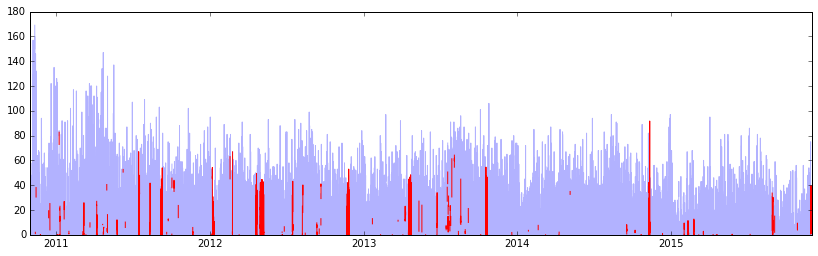

In [30]:
plt.figure(figsize=(14,4))
plt.plot(df_out['waittime'], alpha=.3)
plt.plot(df_out['predict'], color='r');

In [31]:
df_out[~pd.isnull(df_out.predict)].groupby(['year', 'month', 'dayofmonth'])['predict'].count()

year  month  dayofmonth
2010  11     2              1
             3              1
             7              2
             10             1
             11             1
             12             2
             14             2
             15             1
             16             2
             17             2
             18             1
             23             1
             24             3
             25             5
             28             1
             30             2
      12     5              3
             8              2
             10             3
             13             2
             14             4
             15             1
             16             2
             17             4
             19             2
             21             1
             22             2
             23             3
             24             1
             25             1
                           ..
2015  4      22             1
             30 

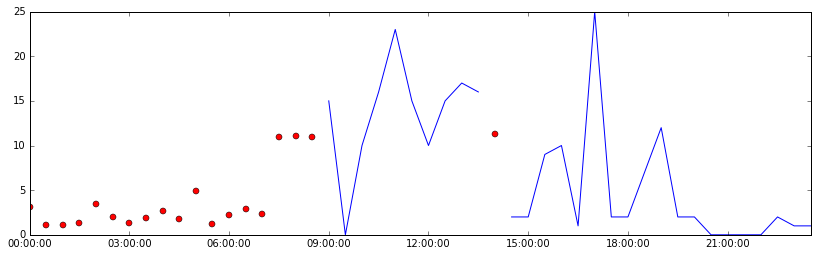

In [32]:
year = 2015
month = 11
day = 30
plt.figure(figsize=(14,4))
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['waittime'])
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['predict'], 'ro');

## Imputed data looks reasonable.  Predict at 5 minute grain.

In [36]:
df_train = df[~((pd.isnull(df.waittime)) | (df.valid == 0))]
df_test = df[(pd.isnull(df.waittime)) | (df.valid == 0)]

In [38]:
y_train = df_train.waittime
X_train = df_train.drop(['date', 'volume', 'waittime', 'valid'], axis=1)
X_test = df_test.drop(['date', 'volume', 'waittime', 'valid'], axis=1)

model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
model.fit(X_train, y_train)

print model.oob_score_

yhat = model.predict(X_test)

0.945294313853


In [39]:
df_hat = df_test.copy()
df_hat['predict'] = yhat
df_hat = df_hat[['date', 'predict']]
df_out = df.merge(df_hat, how='left', on='date').set_index('date')

In [40]:
df_out[~pd.isnull(df_out.predict)].groupby(['year', 'month', 'dayofmonth'])['predict'].count()

year  month  dayofmonth
2010  11     2               1
             3               1
             4               2
             6               1
             7               7
             10              1
             11             10
             12             17
             14             14
             15              5
             16              2
             17              3
             18              2
             21              2
             23              1
             24             14
             25             26
             26              1
             28              5
             29              1
             30              2
      12     5               8
             6               1
             7               3
             8              16
             9               8
             10             15
             11             14
             12             12
             13             14
                          ... 
2015  7      21

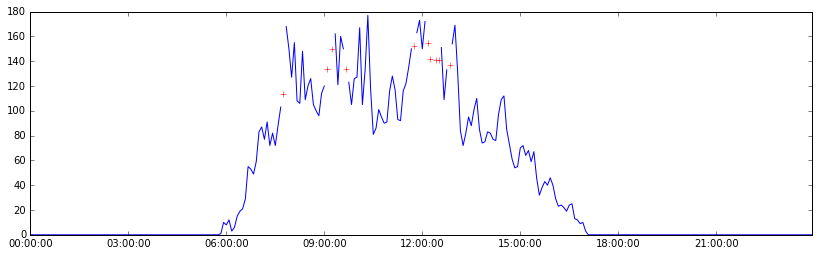

In [53]:
year = 2010
month = 11
day = 11
plt.figure(figsize=(14,4))
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['waittime'])
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['predict'], 'r+');

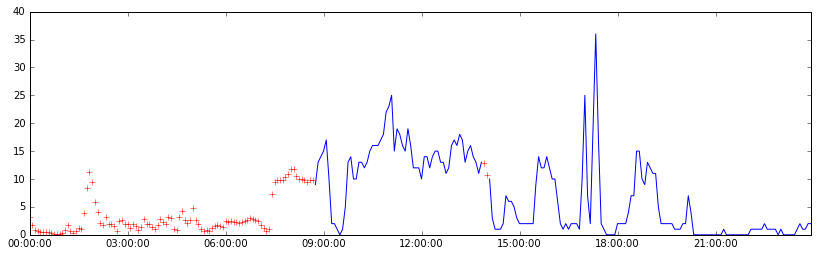

In [56]:
year = 2015
month = 11
day = 30
plt.figure(figsize=(14,4))
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['waittime'])
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['predict'], 'r+');

## .945 OOB score is very high.  Qualitatively, imputed data tends to lie in expected range when filling in gaps.  For longer runs, it is clearly more speculative.

## Smooth with LOWESS
1. Create a data field that combines actual and prediction
2. Perform smoothing on entire data set

In [60]:
df_out['y'] = df_out.apply(lambda x: x.waittime if pd.isnull(x.predict) else x.predict, axis=1)

In [63]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

z = lowess(df_out.y, df_out.index, frac=12./len(df_out), it=1)

In [71]:
df_out['z'] = z[:,1]
df_out.z = df_out.z.clip_lower(0)

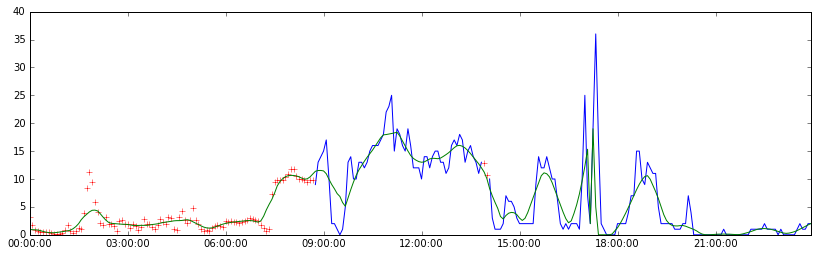

In [72]:
year = 2015
month = 11
day = 30
plt.figure(figsize=(14,4))
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['waittime'])
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['predict'], 'r+');
plt.plot(df_out[(df_out.year == year) & (df_out.month == month) & (df_out.dayofmonth == day)]['z'], color = 'g');

In [82]:
dfcsv = df_out.reset_index()[['date', 'z']]
dfcsv['munger_id'] = 1
dfcsv['crossing_id'] = 1

In [86]:
dfcsv.to_csv('../data/munge1.csv', columns=['munger_id', 'crossing_id', 'date', 'z'], index=False, header=False)